## Cell Count Timeseries Decomposition Analysis (WIP)

In [1]:
# config_path = '/lab/repos/celldom/config/experiment/exp-20180614-G3-K562-imatinib-poc-01.yaml'
# data_dir = '/lab/data/celldom/output/20181005-G3-full'
config_path = "/lab/repos/celldom/config/experiment/exp-20181013-G1v2-K562-imatinib.yaml"
data_dir = "/lab/data/celldom/output/20181128-G1v2-full"

In [2]:
# # %load ../../plotly.py
# import plotly.graph_objs as go
# from plotly.offline import init_notebook_mode, plot, iplot
# init_notebook_mode()

In [3]:
%run -m celldom.nb.logging
%matplotlib inline
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt
from celldom.core import experiment
from celldom.execute import view

In [4]:
exp = experiment.Experiment(config_path, data_dir).build_views()
exp

Name: exp-20181013-G1v2-K562-imatinib
Path: /lab/data/celldom/output/20181128-G1v2-full
Chip: G1v2
Analysis: Default

In [5]:
df_apt = exp.get_view_store().get('apartment')
df_apt = view.remove_oob_apartments(exp, df_apt)
df_apt['array'] = df_apt[exp.config.experimental_condition_fields].apply(':'.join, axis=1)
df_apt['address'] = df_apt[exp.config.apartment_address_fields].apply(':'.join, axis=1)
df_apt.info()

2018-12-04 20:49:56,130:INFO:celldom.execute.view: Removing 2508 rows of 22705 from data frame with apartment/street numbers outside of expected range (apartment range = [0, 46], street range = [0, 31])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20197 entries, 0 to 21496
Data columns (total 36 columns):
acq_apartment             20197 non-null object
acq_cell_line             20197 non-null object
acq_color                 20197 non-null object
acq_concentration         20197 non-null object
acq_condition             20197 non-null object
acq_datetime              20197 non-null datetime64[ns]
acq_drug                  20197 non-null object
acq_hour                  20197 non-null object
acq_id                    20197 non-null object
acq_processed_at          20197 non-null datetime64[ns]
acq_street                20197 non-null object
apt_id                    20197 non-null int64
apt_image_height          20197 non-null int64
apt_image_width           20197 non-null int64
apt_num                   20197 non-null object
apt_num_digit_scores      20197 non-null object
cell_count                20197 non-null float64
focus_score               20197 non-null int64
marker_center_

In [6]:
df_apt_sum = exp.get_view_store().get('apartment_summary')
df_apt_sum = view.remove_oob_apartments(exp, df_apt_sum)
df_apt_sum['address'] = df_apt_sum[exp.config.apartment_address_fields].apply(':'.join, axis=1)
df_apt_sum.info()

2018-12-04 20:49:57,253:INFO:celldom.execute.view: Removing 391 rows of 3351 from data frame with apartment/street numbers outside of expected range (apartment range = [0, 46], street range = [0, 31])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2960 entries, 0 to 3347
Data columns (total 27 columns):
acq_cell_line            2960 non-null object
acq_drug                 2960 non-null object
acq_concentration        2960 non-null object
acq_color                2960 non-null object
acq_condition            2960 non-null object
st_num                   2960 non-null object
apt_num                  2960 non-null object
acq_ids                  2960 non-null object
cell_counts              2960 non-null object
confluence               2960 non-null object
dates                    2960 non-null object
first_date               2960 non-null datetime64[ns]
first_hour               2960 non-null int64
growth_rate              1422 non-null float64
growth_rate_intercept    2960 non-null float64
hours                    2960 non-null object
initial_condition        2960 non-null object
last_date                2960 non-null datetime64[ns]
last_hour                2960 non-null int64
max

In [7]:
# Restrict to apartments with valid growth rate
df = df_apt[df_apt['address'].isin(
    df_apt_sum[df_apt_sum['growth_rate'].notnull()]['address'].unique()
)]

In [8]:
df_apt['array'].value_counts()

K562:Imatinib:150nM:Orange:2    10199
K562:Imatinib:150nM:Orange:1     9998
Name: array, dtype: int64

In [13]:
# Select data for one array and pivot (+interpolate)
arrays = [
# #    'gravity:Pink:1:0.5uM',
# #   'gravity:Pink:3:0.5uM'
# #    'gravity:Red:1:0.5uM'
#     'gravity:Red:3:0.5uM'
# #     'Elveflow:Orange:1:0.1uM',
# #     'gravity:White:3:Control'
# #     'gravity:Orange:3:0.1uM'
# #     'gravity:Yellow:3:0.3uM'
#     'Elveflow:Red:3:Control'
#     'gravity:Blue:3:Control'
# #   'gravity:White:1:Control'
]

arrays = [
   'K562:Imatinib:150nM:Orange:1',
# #    'K562:Imatinib:150nM:Orange:2'
]
df_ts = df[df['array'].isin(arrays)]\
    .pivot_table(index='elapsed_hours_group', columns='address', values='cell_count_any_chamber').sort_index().interpolate().T
assert df_ts.notnull().all().all()
df_ts.head()

elapsed_hours_group,0,18,41,72,92,119,139
address,,,,,,,
K562:Imatinib:150nM:Orange:1:00:02,1.0,3.0,5.0,16.0,27.0,32.0,43.0
K562:Imatinib:150nM:Orange:1:00:03,1.0,2.0,0.0,0.0,0.0,0.0,0.0
K562:Imatinib:150nM:Orange:1:00:06,1.0,2.0,3.0,4.0,3.0,3.0,5.0
K562:Imatinib:150nM:Orange:1:00:07,1.0,2.0,3.0,2.5,2.0,3.0,2.0
K562:Imatinib:150nM:Orange:1:00:08,1.0,4.0,2.0,1.5,1.0,0.0,0.0


In [14]:
df_ts.shape

(778, 7)

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap

X = df_ts.values

n_comp = 2
est = Pipeline([
    #('scale', StandardScaler()),
    ('pca', umap.UMAP(n_neighbors=15, min_dist=.1, random_state=1))
    
])
#df_embed = pd.DataFrame(est.fit_transform(np.log(X + 1))).add_prefix('V')
df_embed = pd.DataFrame(est.fit_transform(X)).add_prefix('V')
df_embed.head()

,V0,V1
0,5.558006,3.146589
1,19.420940,21.296152
2,9.550385,12.216704
3,11.031112,17.438782
4,10.169901,25.187515


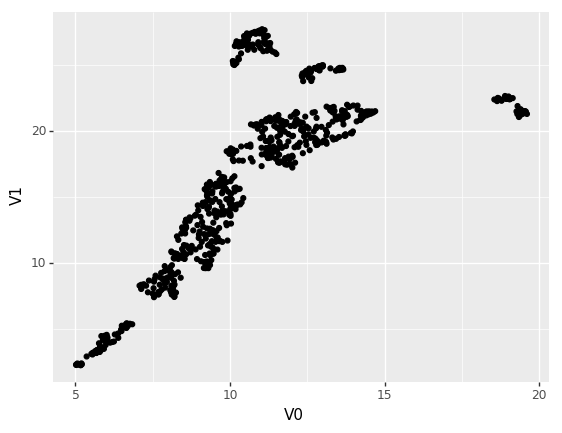

<ggplot: (8766950053019)>

In [18]:
(
    pn.ggplot(df_embed, pn.aes(x='V0', y='V1')) + 
    pn.geom_jitter(width=.1, height=.1)
)

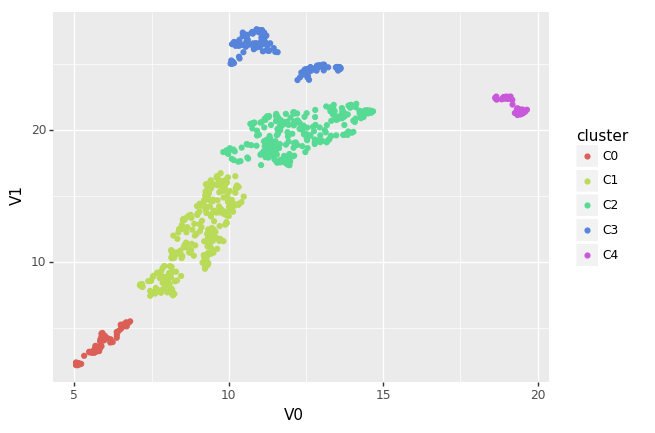

<ggplot: (8766928120061)>

In [58]:
from sklearn.cluster import SpectralClustering


clus = SpectralClustering(n_clusters=5, random_state=1)
clusters = clus.fit_predict(df_embed)

df_res = df_ts.copy()
df_res['cluster'] = clusters
(
    pn.ggplot(df_embed.assign(cluster='C'+pd.Series(clusters).astype(str)), pn.aes(x='V0', y='V1', color='cluster')) + 
    pn.geom_jitter(width=.1, height=.1) 
)

In [60]:
# Show a sample (for example generation in modeling)
def get_sample(g):
    gs = g.sample(n=10, random_state=1)
    gs.index = ['{}:{}'.format(gs['cluster'].iloc[i], gs.index[i]) for i in range(len(gs))]
    gs = gs.drop('cluster', axis=1)
    return gs
    
df_res.groupby('cluster', group_keys=False).apply(get_sample).to_json(orient='index')

'{"0:K562:Imatinib:150nM:Orange:1:16:10":{"0":1.0,"18":2.0,"41":4.0,"72":8.0,"92":14.0,"119":17.0,"139":20.0},"0:K562:Imatinib:150nM:Orange:1:37:11":{"0":1.0,"18":2.0,"41":6.0,"72":11.0,"92":23.0,"119":44.0,"139":63.0},"0:K562:Imatinib:150nM:Orange:1:26:12":{"0":1.0,"18":3.0,"41":4.0,"72":11.5,"92":19.0,"119":29.0,"139":31.0},"0:K562:Imatinib:150nM:Orange:1:17:04":{"0":1.0,"18":2.0,"41":5.0,"72":10.0,"92":17.0,"119":21.0,"139":30.0},"0:K562:Imatinib:150nM:Orange:1:02:25":{"0":1.0,"18":2.0,"41":3.5,"72":5.0,"92":7.0,"119":13.0,"139":16.0},"0:K562:Imatinib:150nM:Orange:1:28:02":{"0":1.0,"18":1.0,"41":4.0,"72":6.0,"92":17.0,"119":21.0,"139":28.0},"0:K562:Imatinib:150nM:Orange:1:45:25":{"0":1.0,"18":2.0,"41":4.0,"72":9.0,"92":10.0,"119":12.0,"139":19.0},"0:K562:Imatinib:150nM:Orange:1:36:03":{"0":1.0,"18":5.0,"41":9.0,"72":25.0,"92":39.0,"119":55.0,"139":13.0},"0:K562:Imatinib:150nM:Orange:1:25:00":{"0":1.0,"18":3.0,"41":8.0,"72":16.0,"92":23.0,"119":31.0,"139":34.0},"0:K562:Imatinib:150nM

In [44]:
df_res['cluster'].nunique()

5

In [38]:
df_res = df_res.set_index('cluster', append=True)
df_res.columns.name = 'hour'
df_res = df_res.stack().rename('count').reset_index()
df_res.head()

,address,cluster,hour,count
0,K562:Imatinib:150nM:Orange:1:00:02,0,0,1.0
1,K562:Imatinib:150nM:Orange:1:00:02,0,18,3.0
2,K562:Imatinib:150nM:Orange:1:00:02,0,41,5.0
3,K562:Imatinib:150nM:Orange:1:00:02,0,72,16.0
4,K562:Imatinib:150nM:Orange:1:00:02,0,92,27.0


In [39]:
df_res.groupby('address')['cluster'].first().value_counts()

2    268
1    258
3    137
0     62
4     53
Name: cluster, dtype: int64

In [40]:
import numpy as np

facet     cluster
C0 (7%)   C0          434
C1 (33%)  C1         1806
C2 (34%)  C2         1876
C3 (17%)  C3          959
C4 (6%)   C4          371
dtype: int64


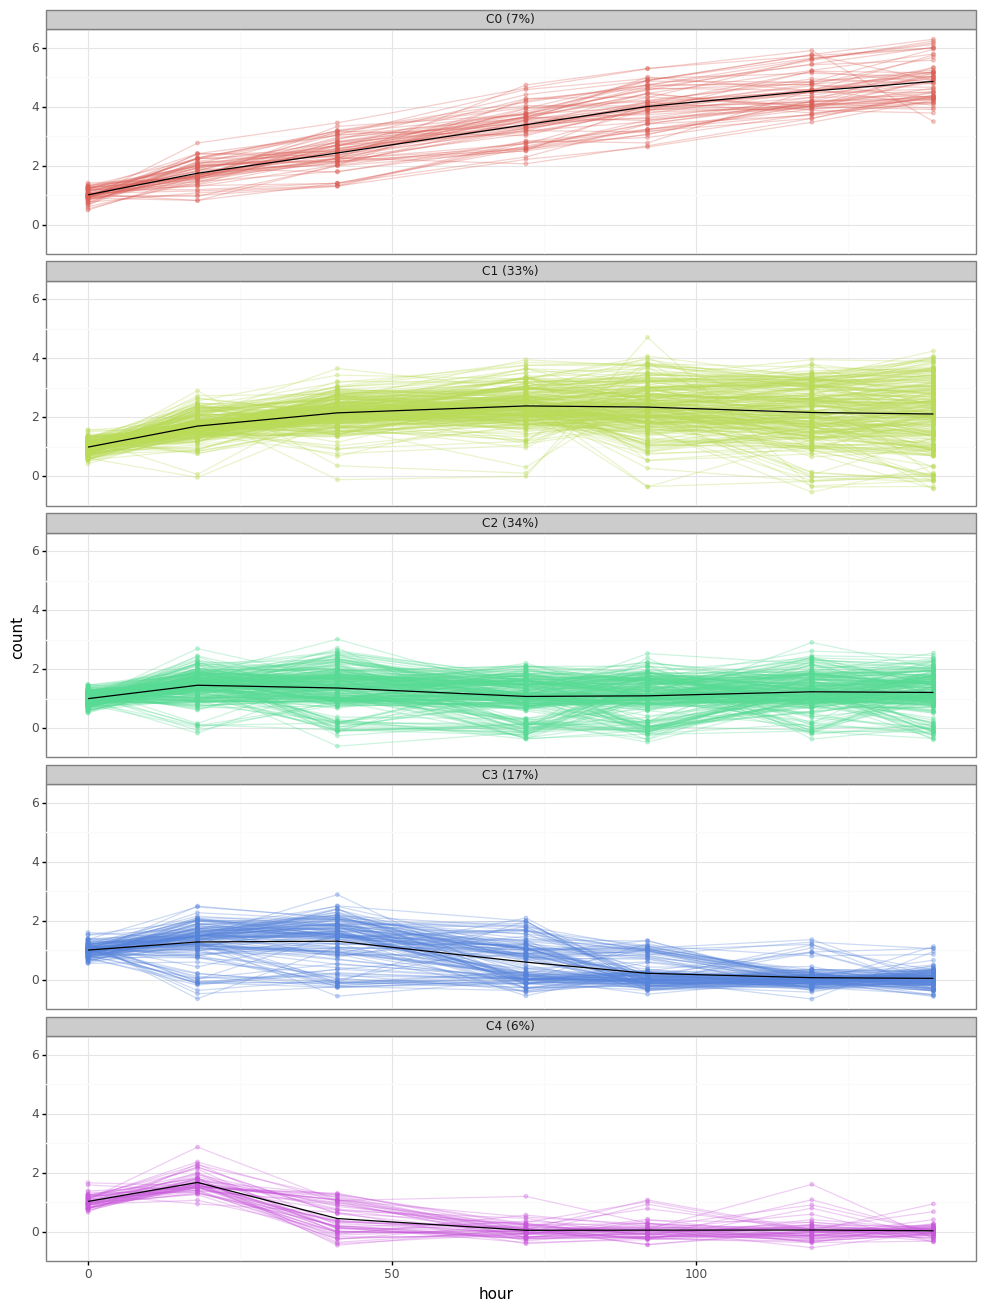

<ggplot: (-9223363269928757949)>

In [41]:
def disp(df):
    dfp = (
        df_res
        #.assign(count=df_res['count'] + np.random.normal(scale=.3, size=len(df_res)))
        .assign(count=np.log2(df_res['count']+1) + np.random.normal(scale=.2, size=len(df_res)))
        .assign(percent=(100*df_res['cluster'].map(df_res['cluster'].value_counts(normalize=True))).astype(int))
        .assign(cluster='C' + df_res['cluster'].astype(str))
        .assign(facet=lambda d: d['cluster'] + ' (' + d['percent'].astype(str) + '%)')
    )
    print(dfp.groupby(['facet', 'cluster']).size())
    return (
        pn.ggplot(dfp, pn.aes(x='hour', y='count', group='address', color='cluster')) + 
        pn.geom_line(alpha=.3) +
        pn.geom_point(alpha=.3, size=1) +
        pn.geom_line(
            data=dfp.groupby(['facet', 'hour'])['count'].mean().rename('count').reset_index(),
            mapping=pn.aes(group='facet'),
            color='black'
        ) +
        pn.scale_color_discrete(guide=False) + 
        pn.facet_wrap('~facet', ncol=1) + 
        pn.theme_bw() +
        pn.theme(figure_size=(12, 16)) 
    )
disp(df_res)